In [48]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Status</span>

Current state of this approach:

- This approach requires its own `Dataset` object
  - ...where we should return the weak labels, avoiding the need of `collate_fn` in `DataLoader`
  - We should probably join all images in train/test folders, since here the training takes a different approach
  - Train/test/val split would be done considering all data at once
- Transformer architecture matches what was described in the paper
  - ...but attention map extraction assumes a single transformer layer
  - ...it is usually pre-trained on a larger dataset, prior to tuning to task at hand
  - ...patch size will ultimately limit the anomaly map resolution
- Training
  - As it is, maybe we don't have enough data to train model completely with weak supervision? Combine available data + pre-training may be required?
- Visualizing attention
  - It remains to be done properly:
    - In order to try to get some visualization, the attention map for given inputs was collapsed into a single channel mask by applying PCA to the $d$-dimensional attention map (where $d$ is the dimension used by transformer)...
    - ...we can see something that seems to make sense? At least, the capsule region gets highlighted, but it doesn't seem to be precise / have enough resolution to properly discern anomalous regions
  - ...literature so far hasn't been very clear on how to do this. Maybe search for better explanaitions/tutorials/implementations?
- Some parts of this are hardcoded to `PATCH_SIZE=50`
  - Easily adapted once the proper infrastructure is implemented
  - Note that number of input parameters does not depend on patch size $$\text{total} = \left(\frac{W}{P}\right)\left(\frac{H}{P}\right)(3P^2) = 3WH = 3\times10^6$$ 
  - Small patch size means more mask resolution, but longer sequences for transformer to process
    - How large can we make resolution without killing processing time?

Conclusion: quite a bit of work remains to be done, but there is some sort of light at the end of the tunnel.

# <span style="color:green">Vision Transformer approach</span>
The ViT is an architecture that leverages transformers to image-based tasks. 

The main idea is to convert input image into a sequence of patches. We embed this sequence with a linear layer, plus positional encoding. Then, we apply a multi-head transformer layer. The output features are then used to solve the given task, e.g. classification.

The idea is to frame our anomaly detection as a weakly supervised problem, where weak binary labels $y$ are given. $y = 0$ means the image is normal, $y=1$ means the image is anomalous. This is called *weak* supervision because no information about *where* the anomaly is (i.e. ground truth mask) is supplied.

Then, we train a ViT in the task of predicting $\hat{y}$. By extracting information from the attention layers inside the transformer, we should be able to obtain anomaly masks. This should be the case because the attention should learn to prioritize anomalous regions in order to perform the classification task.

## DataLoader and data pre-processing

In [2]:
# Load dataset
cat = "capsule"
data = ds.MVTECTestDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat)

# Split data into train/test/val
lengths = torch.floor(torch.tensor([0.8, 0.1, 0.1])*len(data))
diff = torch.abs(lengths.sum() - len(data))
if diff > 0:
    lengths[0] += diff

train_data, test_data, val_data = torch.utils.data.random_split(data, lengths.to(int).tolist())

In [3]:
PATCH_SIZE = 50

def collate_fn(x):
    ''' 
    x: list - batch_size
    
    Converts list of input tensors (C, W, H) to batch.
    Normalizes each image from 0-255 to 0-1.
    For each image, convert it into sequence of W/P vectors of dimension C*P**2,
    where P is a fixed patch size.
    Also computes weak labels (0/1 for normal/anomalous images, respectively)

    output: Tensor - (batch_size, W/P, C*P**2), Tensor - (batch_size, W/P)
    '''   
    # Extract input images and labels
    imgs = [data["test"] for data in x]

    targets = [1 if torch.any(data["ground_truth"] > 0) else 0
               for data in x]

    C, W, H = imgs[0].shape

    # Convert images to 0-1
    imgs = [img / 255.0 for img in imgs]

    # Extract patches 
    patch_size = PATCH_SIZE
    temp = []
    for id, img in enumerate(imgs):
        # Cut up image into flatenned sequence of patches
        patches = [img[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size].flatten()
                   for i in range(W//patch_size) for j in range(H//patch_size)]
        patches = torch.stack(patches)
        temp.append(patches)
    
    # Convert to tensor
    data, targets = torch.stack(temp), torch.tensor(targets)
    return data, targets

In [4]:
# Define DataLoaders for batching input
BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Check if loaders are working properly
def test_dataloader(data_loader):
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:   
        data, targets = batch
    return 

test_dataloader(train_dataloader)

100%|██████████| 27/27 [00:15<00:00,  1.71it/s]


## Defining the model architecture

In [113]:
# Model v1
class VisionTransformer(nn.Module):
    def __init__(self, seq_len, input_features, num_encoder_layers, d_model, nhead):
        '''
        Inputs:
         seq_len: int,  input sequence lenght i.e number of patches
         input_features: int,   (patch_size)**2 * channels
         num_encoder_layers: int,   number of consecutive Transformer layers
         d_model: int,   hidden dimension used throughout Transformers
         nhead: int, number of heads of each Transformer 
        '''
        super().__init__()
        
        self.linear = nn.Linear(in_features=input_features, out_features=d_model)
        self.pe_encoder = PositionalEncoding(d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead),
                                                 num_layers=num_encoder_layers)
        self.output = nn.Linear(in_features=d_model*seq_len, out_features=1)
        

    def forward(self, x):
        logging.debug(f"DTypes: raw input {type(x)}")

        x = self.linear(x)

        logging.debug(f"DTypes: linear output {type(x)}")
        logging.debug(f"PE Encoder: input (after Linear) {x.shape}, permuted {torch.swapdims(x, 0, 1).shape}")

        u = self.pe_encoder(torch.swapdims(x, 0, 1))
        logging.debug(f"PE Encoder: output {u.shape}, permuted: {torch.swapdims(u, 0, 1).shape}")
        x += torch.swapdims(u, 0, 1)
        x = self.encoder(x)
        logging.debug(f"Pre logits: {x.shape}")
        logits = self.output(torch.flatten(x, start_dim=1, end_dim=2))
        logging.debug(f"Logits: {logits.shape}")
        return logits.squeeze()

class PositionalEncoding(nn.Module):
    ''' 
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        logging.debug(f"DTypes: PE before droput output {type(x)}")
        return self.dropout(x)

In [50]:
# Model v2
class VisionTransformer(nn.Module):
    def __init__(self, seq_len, input_features, num_encoder_layers, d_model, nhead):
        '''
        Inputs:
         seq_len: int,  input sequence lenght i.e number of patches
         input_features: int,   (patch_size)**2 * channels
         num_encoder_layers: int,   number of consecutive Transformer layers
         d_model: int,   hidden dimension used throughout Transformers
         nhead: int, number of heads of each Transformer 
        '''
        super().__init__()
        
        self.linear = nn.Linear(in_features=input_features, out_features=d_model)
        self.pe_encoder = nn.Embedding(num_embeddings=seq_len+1, embedding_dim=d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead, batch_first=True),
                                                 num_layers=num_encoder_layers)
        self.output = nn.Linear(in_features=d_model, out_features=1)
        self.seq_len = seq_len

    def forward(self, x):
        N = x.shape[0] # Batch size
        x_embed = self.linear(x) # Embed patch sequence
        positions = torch.stack([torch.arange(0, self.seq_len+1) for _ in range(N)]).to(x.device)
        u = self.pe_encoder(positions) # Compute  class embedding (0) + positional embeddings (1,...,num_patches)
        x_embed += u[:, 1:] # Sum positional embeddings
        logging.debug(f"x: {x_embed.shape}, u: {u.shape}, u[:, 1:]: {u[:, 1:].shape}, u[:, 0]: {u[:, 0].shape}")
        x_embed = torch.cat((x_embed, u[:, 0].unsqueeze(1)), dim=1) # Concatenate class embedding
        out = self.encoder(x_embed) # Apply transformer encoder
        logits = self.output(out[:, 0]) # Only use class embedding for classification
        return logits.squeeze()

## Training and inference routines

In [58]:
# Boilerplate code, copy-paste from previous class work
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        data, targets = batch
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(data)
            preds = torch.sigmoid(logits)
            pred_cats = torch.where(preds > 0.5, 1, 0).squeeze()
            acc = (pred_cats == targets).float().sum()
            acc /= len(targets)
           
        loss = loss_fn(logits.float(), targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get("num_epochs", 100)
    num_epochs_post_unfreeze = kwargs.get("num_epochs_post_unfreeze", 0)
    if num_epochs_post_unfreeze > 0:
        num_epochs += num_epochs_post_unfreeze
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            data, targets = batch
            data, targets = data.to(device), targets.to(device)
    
            model.zero_grad() # initialize gradients to zero
            logits = model(data) # forward pass
            loss = loss_fn(logits.float(), targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = torch.sigmoid(logits)
                pred_cats = torch.where(preds > 0.5, 1, 0).squeeze()
                acc = (pred_cats == targets).float().sum()
                acc /= len(targets)
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

## Model training

In [61]:
# Define DataLoaders for batching input
BATCH_SIZE = 10

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Define training parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

# Define model hyperparameters
SEQUENCE_LENGTH = 400
INPUT_FEATURES = 7500
ENCODER_LAYERS = 1
ENCODER_DIM = 128
ENCODER_HEADS = 8

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Instantiate model and optimizer
model = VisionTransformer(SEQUENCE_LENGTH, INPUT_FEATURES, ENCODER_LAYERS, ENCODER_DIM, ENCODER_HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: cuda


In [62]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/50


loss = 0.462 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Train loss: 0.590 | train acc = 0.776


loss = 0.231 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Validation loss: 0.232 | val acc = 1.000

Epoch 2/50


loss = 0.467 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


Train loss: 0.488 | train acc = 0.812


loss = 0.180 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Validation loss: 0.180 | val acc = 1.000

Epoch 3/50


loss = 0.199 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


Train loss: 0.481 | train acc = 0.818


loss = 0.193 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


Validation loss: 0.193 | val acc = 1.000

Epoch 4/50


loss = 0.438 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


Train loss: 0.485 | train acc = 0.812


loss = 0.203 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Validation loss: 0.204 | val acc = 1.000

Epoch 5/50


loss = 1.244 | acc = 0.333: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Train loss: 0.513 | train acc = 0.794


loss = 0.201 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Validation loss: 0.201 | val acc = 1.000

Epoch 6/50


loss = 0.273 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Train loss: 0.490 | train acc = 0.818


loss = 0.253 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Validation loss: 0.253 | val acc = 1.000

Epoch 7/50


loss = 0.189 | acc = 1.000: 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Train loss: 0.474 | train acc = 0.818


loss = 0.177 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Validation loss: 0.177 | val acc = 1.000

Epoch 8/50


loss = 0.193 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Train loss: 0.480 | train acc = 0.818


loss = 0.182 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Validation loss: 0.182 | val acc = 1.000

Epoch 9/50


loss = 0.707 | acc = 0.667: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Train loss: 0.495 | train acc = 0.806


loss = 0.205 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Validation loss: 0.206 | val acc = 1.000

Epoch 10/50


loss = 0.921 | acc = 0.500: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Train loss: 0.502 | train acc = 0.800


loss = 0.211 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Validation loss: 0.212 | val acc = 1.000

Epoch 11/50


loss = 1.000 | acc = 0.500: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Train loss: 0.513 | train acc = 0.800


loss = 0.183 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Validation loss: 0.183 | val acc = 1.000

Epoch 12/50


loss = 0.458 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Train loss: 0.490 | train acc = 0.812


loss = 0.260 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Validation loss: 0.260 | val acc = 1.000

Epoch 13/50


loss = 0.727 | acc = 0.667: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


Train loss: 0.499 | train acc = 0.806


loss = 0.175 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Validation loss: 0.176 | val acc = 1.000

Epoch 14/50


loss = 0.245 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Train loss: 0.485 | train acc = 0.818


loss = 0.229 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Validation loss: 0.229 | val acc = 1.000

Epoch 15/50


loss = 0.193 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


Train loss: 0.475 | train acc = 0.818


loss = 0.184 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Validation loss: 0.184 | val acc = 1.000

Epoch 16/50


loss = 0.199 | acc = 1.000: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Train loss: 0.479 | train acc = 0.818


loss = 0.186 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Validation loss: 0.186 | val acc = 1.000

Epoch 17/50


loss = 0.461 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Train loss: 0.488 | train acc = 0.812


loss = 0.186 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Validation loss: 0.186 | val acc = 1.000

Epoch 18/50


loss = 0.460 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Train loss: 0.482 | train acc = 0.812


loss = 0.218 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Validation loss: 0.218 | val acc = 1.000

Epoch 19/50


loss = 0.479 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Train loss: 0.486 | train acc = 0.812


loss = 0.226 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Validation loss: 0.227 | val acc = 1.000

Epoch 20/50


loss = 0.215 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Train loss: 0.480 | train acc = 0.818


loss = 0.200 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


Validation loss: 0.200 | val acc = 1.000

Epoch 21/50


loss = 0.465 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Train loss: 0.490 | train acc = 0.812


loss = 0.210 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation loss: 0.211 | val acc = 1.000

Epoch 22/50


loss = 0.766 | acc = 0.667: 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


Train loss: 0.503 | train acc = 0.806


loss = 0.155 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Validation loss: 0.155 | val acc = 1.000

Epoch 23/50


loss = 0.694 | acc = 0.667: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Train loss: 0.503 | train acc = 0.806


loss = 0.237 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


Validation loss: 0.237 | val acc = 1.000

Epoch 24/50


loss = 0.438 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


Train loss: 0.489 | train acc = 0.812


loss = 0.186 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Validation loss: 0.187 | val acc = 1.000

Epoch 25/50


loss = 0.450 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


Train loss: 0.481 | train acc = 0.812


loss = 0.209 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Validation loss: 0.209 | val acc = 1.000

Epoch 26/50


loss = 0.461 | acc = 0.833: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]


Train loss: 0.483 | train acc = 0.812


loss = 0.216 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Validation loss: 0.216 | val acc = 1.000

Epoch 27/50


loss = 0.719 | acc = 0.667: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


Train loss: 0.498 | train acc = 0.806


loss = 0.205 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Validation loss: 0.206 | val acc = 1.000

Epoch 28/50


loss = 0.250 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Train loss: 0.478 | train acc = 0.818


loss = 0.233 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Validation loss: 0.234 | val acc = 1.000

Epoch 29/50


loss = 1.069 | acc = 0.500: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Train loss: 0.519 | train acc = 0.800


loss = 0.154 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Validation loss: 0.155 | val acc = 1.000

Epoch 30/50


loss = 0.466 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


Train loss: 0.494 | train acc = 0.812


loss = 0.253 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Validation loss: 0.252 | val acc = 1.000

Epoch 31/50


loss = 0.250 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Train loss: 0.480 | train acc = 0.818


loss = 0.229 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Validation loss: 0.229 | val acc = 1.000

Epoch 32/50


loss = 0.191 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Train loss: 0.470 | train acc = 0.818


loss = 0.180 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Validation loss: 0.180 | val acc = 1.000

Epoch 33/50


loss = 0.456 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Train loss: 0.488 | train acc = 0.812


loss = 0.170 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Validation loss: 0.170 | val acc = 1.000

Epoch 34/50


loss = 0.452 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Train loss: 0.485 | train acc = 0.812


loss = 0.200 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Validation loss: 0.199 | val acc = 1.000

Epoch 35/50


loss = 0.450 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


Train loss: 0.479 | train acc = 0.812


loss = 0.239 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Validation loss: 0.239 | val acc = 1.000

Epoch 36/50


loss = 0.682 | acc = 0.667: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


Train loss: 0.495 | train acc = 0.806


loss = 0.202 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Validation loss: 0.202 | val acc = 1.000

Epoch 37/50


loss = 0.681 | acc = 0.667: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Train loss: 0.487 | train acc = 0.806


loss = 0.199 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Validation loss: 0.200 | val acc = 1.000

Epoch 38/50


loss = 0.238 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Train loss: 0.473 | train acc = 0.818


loss = 0.227 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


Validation loss: 0.230 | val acc = 1.000

Epoch 39/50


loss = 0.451 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


Train loss: 0.482 | train acc = 0.812


loss = 0.203 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Validation loss: 0.205 | val acc = 1.000

Epoch 40/50


loss = 0.194 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Train loss: 0.475 | train acc = 0.818


loss = 0.190 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Validation loss: 0.191 | val acc = 1.000

Epoch 41/50


loss = 0.430 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Train loss: 0.483 | train acc = 0.812


loss = 0.194 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Validation loss: 0.197 | val acc = 1.000

Epoch 42/50


loss = 0.235 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Train loss: 0.475 | train acc = 0.818


loss = 0.233 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


Validation loss: 0.233 | val acc = 1.000

Epoch 43/50


loss = 0.209 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Train loss: 0.466 | train acc = 0.818


loss = 0.203 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


Validation loss: 0.204 | val acc = 1.000

Epoch 44/50


loss = 0.701 | acc = 0.667: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Train loss: 0.489 | train acc = 0.806


loss = 0.196 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Validation loss: 0.197 | val acc = 1.000

Epoch 45/50


loss = 0.479 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Train loss: 0.487 | train acc = 0.812


loss = 0.244 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Validation loss: 0.246 | val acc = 1.000

Epoch 46/50


loss = 0.453 | acc = 0.833: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


Train loss: 0.480 | train acc = 0.812


loss = 0.199 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Validation loss: 0.203 | val acc = 1.000

Epoch 47/50


loss = 0.208 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Train loss: 0.477 | train acc = 0.818


loss = 0.208 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Validation loss: 0.206 | val acc = 1.000

Epoch 48/50


loss = 0.430 | acc = 0.833: 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Train loss: 0.477 | train acc = 0.812


loss = 0.208 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Validation loss: 0.206 | val acc = 1.000

Epoch 49/50


loss = 0.207 | acc = 1.000: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Train loss: 0.468 | train acc = 0.818


loss = 0.186 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Validation loss: 0.195 | val acc = 1.000

Epoch 50/50


loss = 0.241 | acc = 1.000: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


Train loss: 0.473 | train acc = 0.818


loss = 0.254 | acc = 1.000: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

Validation loss: 0.249 | val acc = 1.000


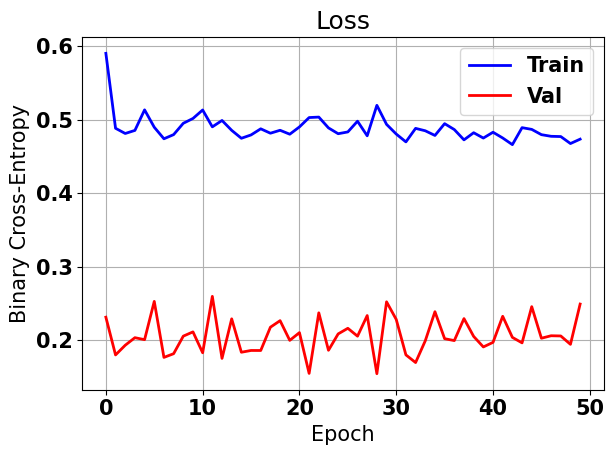

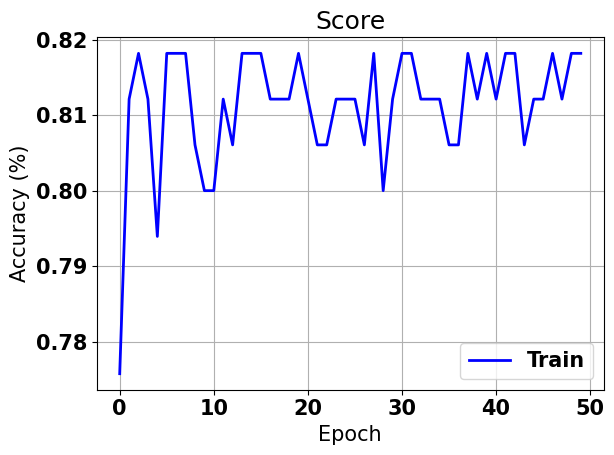

In [159]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    # plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Visualize attention (WoP)

### Warning: highly experimental code below, not good for much

In order to visualize attention, we will follow [this notebook](https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook) and the article *"Quantifying Attention Flow in Transformers - Samira Abnar, Willem Zuidema"*

The basic idea is to retrieve attention values from transformer. Consider a single multi-head attention layer:

1. Average attention accross heads
2. Multiply attention matrices of consecutive blocks in order to accumulate their effect

**Note**

Proper visualization wasn't achieved yet.

In [144]:
# Only works for ENCODER_LAYERS = 1

model.eval()

def extract_attention_maps(model, data):
    '''
    Input
     model - trained VisionTransformer instance
     data - output we get from DataLoader

    Output
     attention - values of self-attention layer for each input in batch
     attention_weights - average over heads of attention weights
    '''
    with torch.no_grad():
        # Pre-process data with embedding layers
        N = data.shape[0] # Batch size
        x_embed = model.linear(data) # Embed patch sequence
        positions = torch.stack([torch.arange(0, model.seq_len+1) for _ in range(N)]).to(data.device)
        u = model.pe_encoder(positions) # Compute  class embedding (0) + positional embeddings (1,...,num_patches)
        x_embed += u[:, 1:] # Sum positional embeddings
        x_embed = torch.cat((x_embed, u[:, 0].unsqueeze(1)), dim=1) # Concatenate class embedding
        
        # Apply self-attention
        transformer_layers = model.encoder.layers[0]
        attention, attention_weights = transformer_layers.self_attn(x_embed, x_embed, x_embed,
                                                                    need_weights=True, average_attn_weights=True)
    return attention, attention_weights


attn_results, attn_weights_results = [] ,[]
raw_images, raw_targets = [], []
pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
for i, batch in pbar:   
    data, targets = batch
    raw_images.append(data.cpu().detach().numpy())
    
    data, targets = data.to(DEVICE), targets.to(DEVICE)
    attn, attn_weights = extract_attention_maps(model, data)
    attn_results.append(attn.cpu().detach().numpy())
    attn_weights_results.append(attn_weights.cpu().detach().numpy())
    
    raw_targets.append(targets.cpu().detach().numpy())

100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


In [145]:
attn_results[0].shape, attn_weights_results[0].shape

((10, 401, 128), (10, 401, 401))

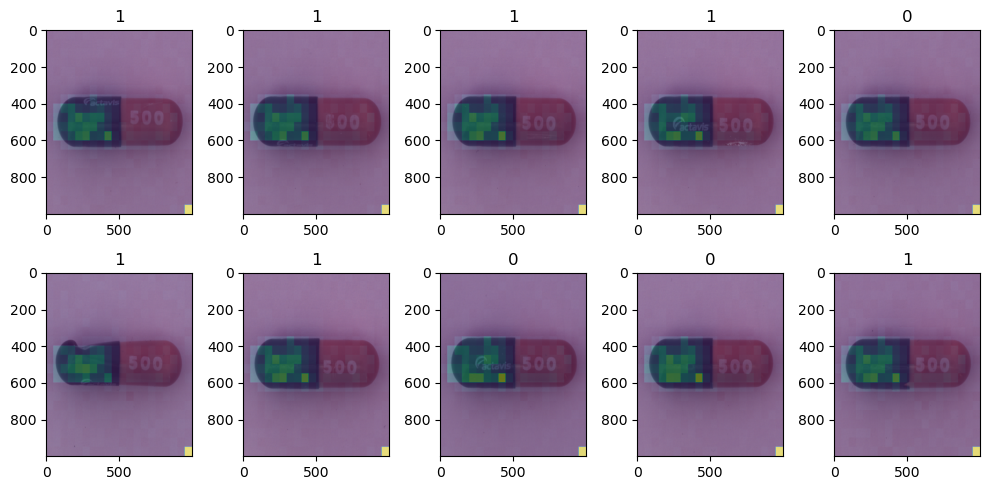

In [158]:
from sklearn.decomposition import PCA

imgs = []
NUM_COMP = 3
for sample_id in range(BATCH_SIZE):
    class_attn = attn_results[0][sample_id, 0] # Class
    pos_attn = attn_results[0][sample_id, 1:] # Patches
    raw = raw_images[0]
    labels = raw_targets[0]

    pca = PCA(n_components=NUM_COMP)
    output = pca.fit_transform(pos_attn)
    output = output.mean(-1)

    img = np.zeros((1000, 1000))
    patch = np.ones((50, 50))
    c = 0
    for i in range(20):
        for j in range(20):
            img[i*50:(i+1)*50, j*50:(j+1)*50] = output[c]*patch
            c += 1
    img = (img - img.min())/(img.max() - img.min())
    imgs.append(img)

fig, ax = plt.subplots(2, 5, figsize=(10, 5))
idx = [(i, j) for i in range(2) for j in range(5)]
for i, img in enumerate(imgs):
    ca = ax[idx[i]]

    y = raw[i]
    temp = np.zeros((3, 1000, 1000))
    c = 0
    for j in range(20):
        for k in range(20):
            patch = y[c]
            temp[:, j*50:(j+1)*50, k*50:(k+1)*50] = patch.reshape(3, 50, 50)
            c += 1
    temp = np.swapaxes(temp, 0, 2)
    temp = np.swapaxes(temp, 0, 1)
    ca.imshow(temp, aspect="auto")
    ca.imshow(img, aspect="auto", cmap="viridis", alpha=0.5)
    ca.set_title(labels[i])
fig.tight_layout()
plt.show()
